# Assignment 4

### Land Use Classification
Land use classification helps us understand how different types of land are used or managed, such as distinguishing between farmland, forests, water, or cities. Sentinel-2, a satellite mission by the European Space Agency (ESA), captures detailed images across multiple spectral bands, making it very useful for this purpose. By offering a view of the Earth at 10 to 60-meter resolutions and revisiting the same spot every 5 days at the equator, Sentinel-2 helps monitor changes in land use efficiently. These images give data to study vegetation, soil, water, and urban areas, enabling analysts to track changes and plan accordingly. This information supports agriculture, city planning, environmental protection, and conservation, ultimately assisting governments and organizations in making better, data-driven decisions about land.

### Labeling
Labeling land use data is an important step in preparing for land use classification tasks since it provides the foundation for training and assessing machine learning models. In this assignment, the labeling process was done manually, with individual places on a computer map being assigned to one of four predefined categories: water, road, urban, or green areas. Each chosen point was thoroughly examined to ensure it appropriately represented one of these categories. This hand assignment method produced labeled data points with corresponding geographical coordinates, resulting in an organized dataset. A labeled dataset is required for training machine learning models to discover patterns and reliably classify new, previously unknown data.

### Classes
The objectives and requirements of the analysis influence the choice of classes for a land use classification work; the ideal number of classes is not predetermined. Rather, this choice depends on several variables, such as the desired level of classification granularity, soil properties, population density, climate, and regional geography. Finding the ideal balance is essential because too many classes can make the model too complicated and challenging to understand, which could lower its performance, while too few classes could ignore significant land use differences. For example, using distinct classes for various kinds of vegetation or metropolitan areas may improve detail but also add needless complexity. Therefore, selecting a categorization strategy that incorporates important land use distinctions without sacrificing model efficiency is carefully considered. For our image, the classes we used are :
1. River Class
2. Agriculture
3. Barren
4. Urban
5. Inland-Water

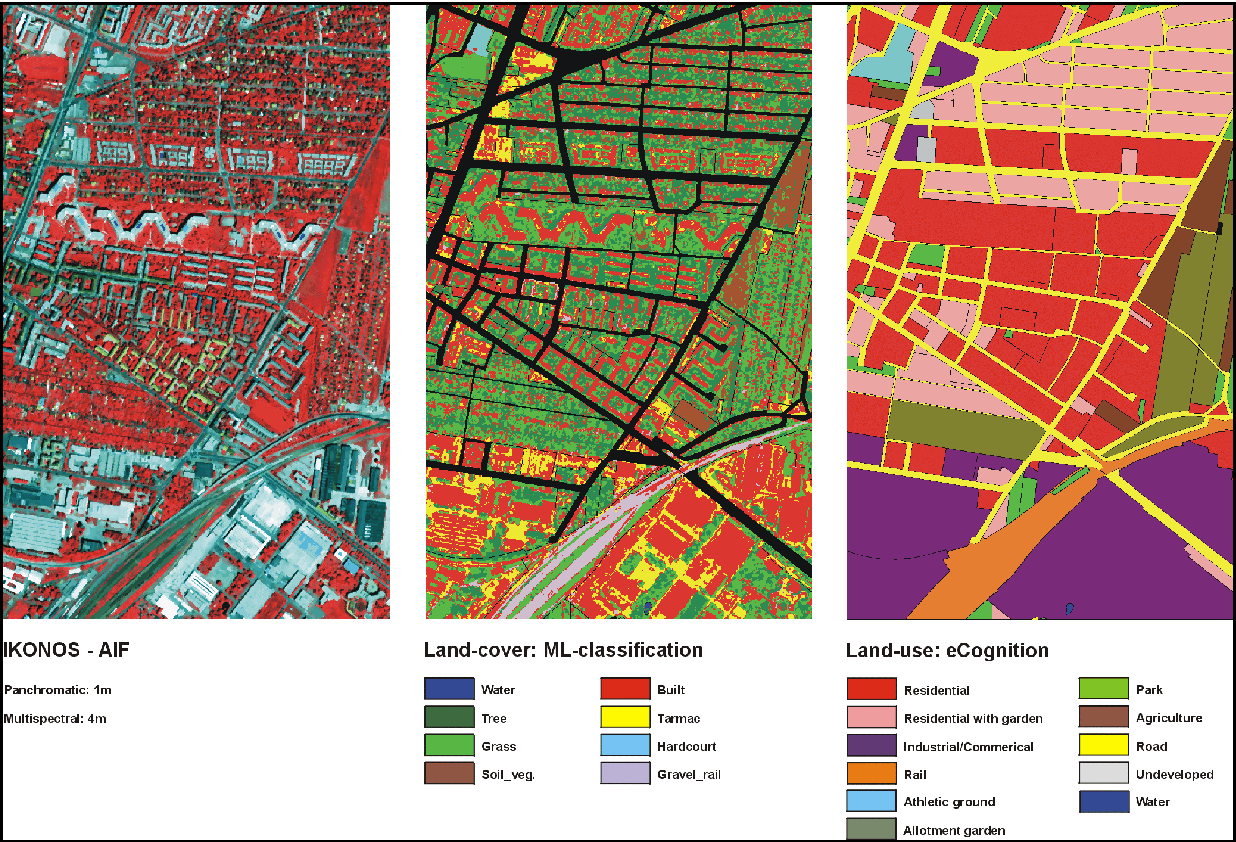


### Use of Random forest for land use Classification
The Random Forest classifier, from the sklearn.ensemble library, is a flexible and widely used tool for both classification and regression tasks. This algorithm creates an "ensemble" of decision trees, where each tree is constructed using a different subset of data selected from the training set through a technique called bootstrapping, or sampling with replacement. In geospatial applications and remote sensing, Random Forest is especially valued for tasks like land use and land cover classification. Here, the algorithm analyzes various image features—such as spectral bands, vegetation indices, and texture patterns from satellite or aerial imagery—to accurately categorize different land use types within a given area.


In [2]:
#adding libraries
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.backend_bases import MouseButton
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Visualisation of Sentinel-2 Image

In [4]:
# Function to stretch colors to improve image visualization
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors

#assign color map
def get_cmap(class_prediction):
    n = class_prediction.max()
    # Next setup a colormap for our map
    colors = dict((
        (0, (240, 240, 240, 255)),  # No Data - Light Gray
        (1, (30, 144, 255, 255)),   # Water - Dodger Blue
        (2, (50, 205, 50, 255)),    # Agriculture - Lime Green
        (3, (218, 165, 32, 255)),   # Barren - Goldenrod
        (4, (255, 99, 71, 255)),    # Urban - Tomato Red
        (5, (70, 130, 180, 255))    # Inland Water - Steel Blue
    ))
    # Put 0 - 255 as float 0 - 1
    for k in colors:
        v = colors[k]
        _v = [_v / 255.0 for _v in v]
        colors[k] = _v
        
    index_colors = [colors[key] if key in colors else 
                    (255, 255, 255, 0) for key in range(1, n + 1)]
    cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

    return cmap


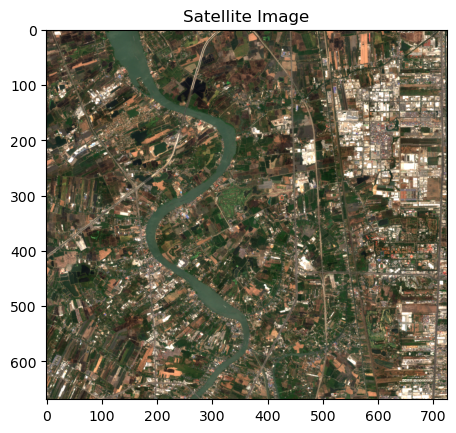

In [6]:
# Load the Sentinel imagery data from the .npz file
inp = np.load("data.npz") #load the data .npz 
img = inp["arr_0"] #satellite image

# Apply color stretch to RGB bands
img_p = color_stretch(img, [3,2,1], (0, 0.3)) 
plt.imshow(img_p)
plt.title("Satellite Image")
plt.savefig("image.png", dpi=180, format='png', bbox_inches='tight', pad_inches=0)
plt.show()

Data points were clicked on the provided sentinel image and landuse classes were manually added. The above-mentioned landuse and their classes were used. **Each student** did about **100-150** points for their respective classes assigned and later combined for the prediction

In [8]:
import cv2
# Load the processed image
img = cv2.imread("image.png")

# Set initial zoom, pan, and drag values
zoom_scale = 1.0  # Initial zoom level
zoom_increment = 0.1  # Zoom step
x_offset, y_offset = 0, 0  # Initial pan offset
is_dragging = False  # Flag to track if dragging
drag_start_x, drag_start_y = 0, 0  # Drag start coordinates

# Function to display a zoomed and panned region of the image
def display_zoomed_image():
    h, w = img.shape[:2]
    # Calculate zoomed image size and apply offsets for panning
    zoomed_img = cv2.resize(img, (int(w * zoom_scale), int(h * zoom_scale)))
    zoomed_img = zoomed_img[y_offset:y_offset + h, x_offset:x_offset + w]
    cv2.imshow("pic", zoomed_img)

# Mouse callback function to handle clicks, zoom, and pan
def click_event(event, x, y, flags, params):
    global zoom_scale, x_offset, y_offset, is_dragging, drag_start_x, drag_start_y

    if event == cv2.EVENT_MOUSEWHEEL:
        # Handle zoom in/out
        if flags > 0:  # Scroll up to zoom in
            zoom_scale = min(zoom_scale + zoom_increment, 3.0)  # Cap max zoom
        else:  # Scroll down to zoom out
            zoom_scale = max(zoom_scale - zoom_increment, 0.5)  # Min zoom limit
        display_zoomed_image()

    elif event == cv2.EVENT_LBUTTONDOWN:
        # Start panning by tracking the starting coordinates
        is_dragging = True
        drag_start_x, drag_start_y = x, y
        
        # Calculate original image coordinates
        orig_x = int((x / zoom_scale) + x_offset)
        orig_y = int((y / zoom_scale) + y_offset)
        print(f"Clicked coordinates: ({orig_x}, {orig_y})")
        
        # Draw a circle on the image where the click occurred
        cv2.circle(img, (orig_x, orig_y), 5, (255, 0, 0), -1)  # Red circle with radius 5
        display_zoomed_image()  # Update the displayed image with the new circle

    elif event == cv2.EVENT_MOUSEMOVE:
        if is_dragging:
            # Calculate the pan offset based on drag distance
            dx, dy = x - drag_start_x, y - drag_start_y
            h, w = img.shape[:2]
            x_offset = np.clip(x_offset - dx, 0, int(w * zoom_scale) - w)
            y_offset = np.clip(y_offset - dy, 0, int(h * zoom_scale) - h)
            drag_start_x, drag_start_y = x, y  # Update drag start
            display_zoomed_image()

    elif event == cv2.EVENT_LBUTTONUP:
        # Stop panning when the left mouse button is released
        is_dragging = False

# Initialize window and set mouse callback
cv2.namedWindow("pic", cv2.WINDOW_NORMAL)
cv2.setMouseCallback("pic", click_event)

# Display the initial image
display_zoomed_image()

# Wait for a key press and close the window
cv2.waitKey(0)
cv2.destroyAllWindows()

          x      y  class
0     135.0   10.0      1
1     149.0    7.0      1
2     142.0   18.0      1
3     147.0   26.0      1
4     153.0   32.0      1
...     ...    ...    ...
5872   30.0  204.0      5
5873   32.0  203.0      5
5874   25.0  206.0      5
5875   22.0  208.0      5
5876   20.0  210.0      5

[5877 rows x 3 columns]
         x      y  class
0    147.0  129.0      3
1    152.0  130.0      3
2    154.0  128.0      3
3    179.0  203.0      3
4    185.0  201.0      3
..     ...    ...    ...
106  434.0  432.0      3
107  448.0  464.0      3
108  186.0  587.0      3
109  188.0  580.0      3
110  189.0  583.0      3

[111 rows x 3 columns]


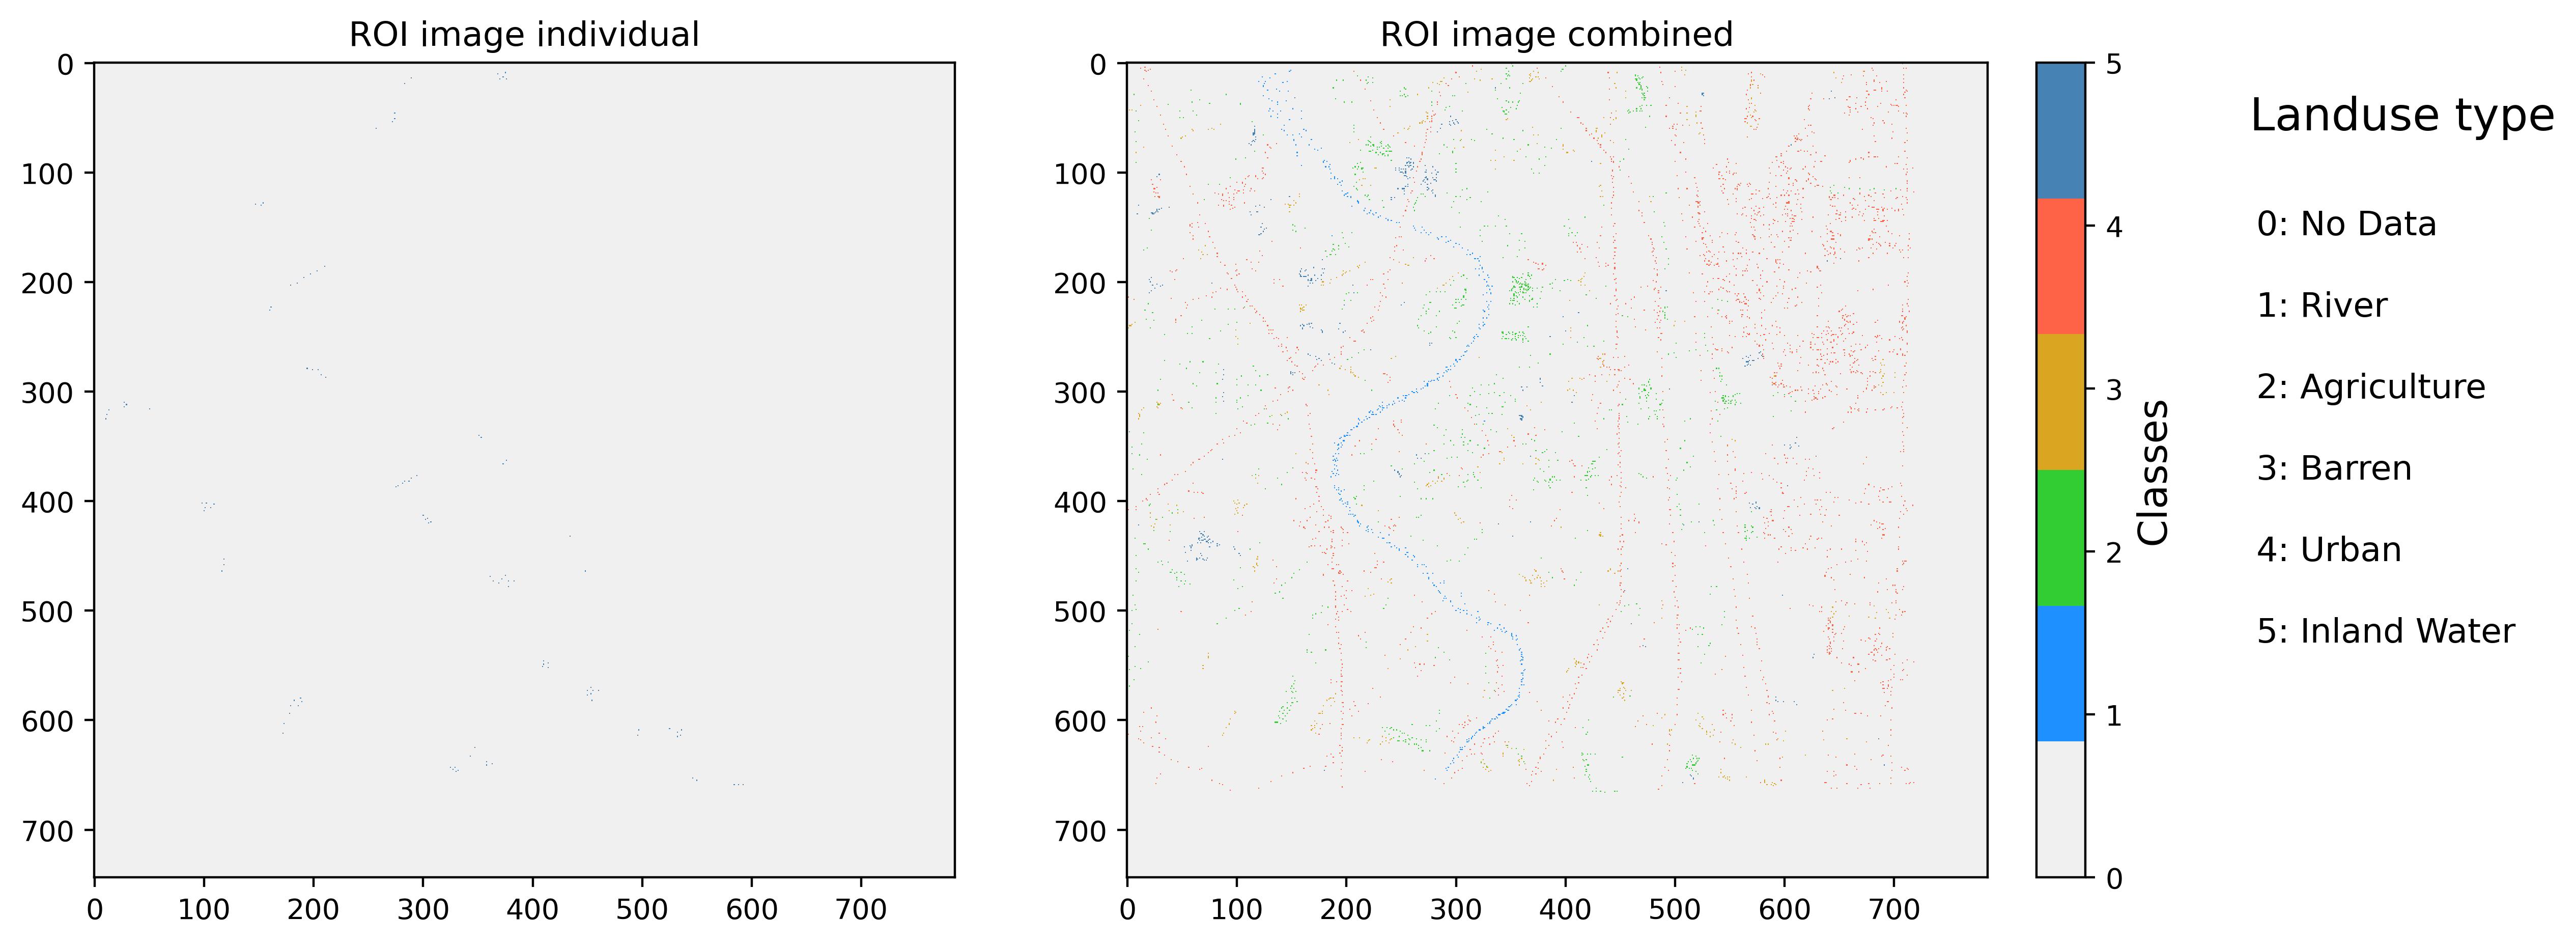

In [10]:
# Function to load data from text files
def get_dataframe(fname, lc_code):
    data = np.loadtxt(fname)
    df = pd.DataFrame(data, columns=['x', 'y'])
    df['class'] = lc_code
    return df

# Load individual land use data for combined ROI
river_c = get_dataframe('river.txt', 1)
agriculture_c = get_dataframe('agriculture.txt', 2)
barren_c = get_dataframe('barren.txt', 3)
urban_c = get_dataframe('urban.txt', 4)
inland_water_c = get_dataframe('inland-water.txt', 5)

# Merge DataFrames into a single DataFrame for combined ROI
roi_df_c = pd.concat([river_c, agriculture_c, barren_c, urban_c, inland_water_c], ignore_index=True)
print(roi_df_c)

# Create an empty array for combined ROI labels
roi_c = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

# Assign land use codes to pixels in the combined ROI array
for index, row in roi_df_c.iterrows():
    x, y, lu_class = int(row['x']), int(row['y']), int(row['class'])
    roi_c[y, x] = lu_class

data = np.loadtxt('barren_saurav.txt', delimiter='\t')
roi_df_s = pd.DataFrame(data, columns = ['x','y'])
roi_df_s['class'] = 3 

print(roi_df_s)
# Create an empty array for individual ROI labels
roi_s = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

# Assign land use codes to pixels in the individual ROI array
for index, row in roi_df_s.iterrows():
    x, y, lu_code = int(row['x']), int(row['y']), int(row['class'])
    roi_s[y, x] = lu_code

colors = [
    '#F0F0F0',  # No Data - Light Gray
    '#1E90FF',  # Water - Dodger Blue
    '#32CD32',  # Agriculture - Lime Green
    '#DAA520',  # Barren - Goldenrod
    '#FF6347',  # Urban - Tomato Red
    '#4682B4'   # Inland Water - Steel Blue
]
custom_cmap = ListedColormap(colors)

# Create a figure to control subplots and colorbar placement
fig = plt.figure(figsize=(12, 8), dpi=400)

# Plot individual ROI image on the left
plt.subplot(121)
img_h = plt.imshow(roi_s, cmap=custom_cmap, interpolation='none')
plt.title("ROI image individual")

# Plot combined ROI image on the right
plt.subplot(122)
img_c = plt.imshow(roi_c, cmap=custom_cmap, interpolation='none')
plt.title("ROI image combined")

# Add color bar next to the right subplot
cbar_ax = fig.add_axes([0.92, 0.245, 0.02, 0.5])  # Adjust position as needed
cbar = fig.colorbar(img_c, cax=cbar_ax, ticks=np.arange(0, 6))  # Adjust ticks for 6 classes
cbar.set_label('Classes', fontsize=14)

# Add a title for the legend
cbar.ax.text(7.5, 4.8, 'Landuse type', fontsize=16, va='top', ha='center')

# Add class labels next to the color bar with increased line spacing in reverse order
class_labels = ['0: No Data','1: River', '2: Agriculture', '3: Barren', '4: Urban', '5: Inland Water']
spacing = 0.5  # Adjust this value to increase/decrease spacing

cbar.ax.text(4.5, 4, class_labels[0], va='center', fontsize=12, ha='left')
cbar.ax.text(4.5, 3.5, class_labels[1], va='center', fontsize=12, ha='left')
cbar.ax.text(4.5, 3.0, class_labels[2], va='center', fontsize=12, ha='left')
cbar.ax.text(4.5, 2.5, class_labels[3], va='center', fontsize=12, ha='left')
cbar.ax.text(4.5, 2.0, class_labels[4], va='center', fontsize=12, ha='left')
cbar.ax.text(4.5, 1.5, class_labels[5], va='center', fontsize=12, ha='left')

#plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar
plt.show()


The left image shows the total number of points that I had selected. My part was to select 100-150 points for the class **barren**. I chose 111 points, which we can call as datasets. For the total number of datasets collected from all the students, we have **5877** training datasets.

In [ ]:

def train_and_classify(img, roi_df, n_estimators=500):
    """
    Trains a Random Forest and returns the out-of-bag score along with class predictions.

    Parameters:
        img (numpy.ndarray): The input image array (height x width x bands).
        roi_df (pd.DataFrame): DataFrame containing ROI coordinates and class labels.
        n_estimators (int): Number of trees in the forest.
        
    Returns:
        tuple: Out-of-bag score (float) and classified image array (numpy.ndarray).
    """
    # Create an empty array to store ROI labels, same dimensions as the input image
    roi = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    # Assign each land use code to the corresponding pixel in the ROI array
    for index, row in roi_df.iterrows():
        x, y, lu_class = int(row['x']), int(row['y']), int(row['class'])
        roi[y, x] = lu_class
    
    # Prepare training data by selecting pixels with valid labels in the image
    X = img[roi > 0, :]  # Features from the image where ROI is valid
    y = roi[roi > 0]     # Labels from ROI
    
    # Train the Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=n_estimators, oob_score=True, random_state=42)
    rf.fit(X, y)
    
    # Compute the out-of-bag score
    oob_score = rf.oob_score_

    # Predict classes for the entire image
    img_reshaped = img.reshape((-1, img.shape[2]))
    class_prediction = rf.predict(img_reshaped).reshape(img.shape[:2])

    return oob_score, class_prediction

# Define the ROIs to combine
rois = [river_c, agriculture_c, barren_c, urban_c, inland_water_c]

# Create and evaluate combined ROIs
results = {}
for i in range(2, 6):  # Starting from roi_2 to roi_5
    combined_roi = pd.concat(rois[:i], ignore_index=True)
    oob_score, class_prediction = train_and_classify(img, combined_roi)
    results[f'roi_{i}'] = (oob_score, class_prediction)
    print(f"OOB score for roi_{i}: {oob_score:.2f}")



OOB score for roi_2: 0.68
OOB score for roi_3: 0.50


C:\Users\Admin\AppData\Local\Temp\ipykernel_19008\2029868717.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


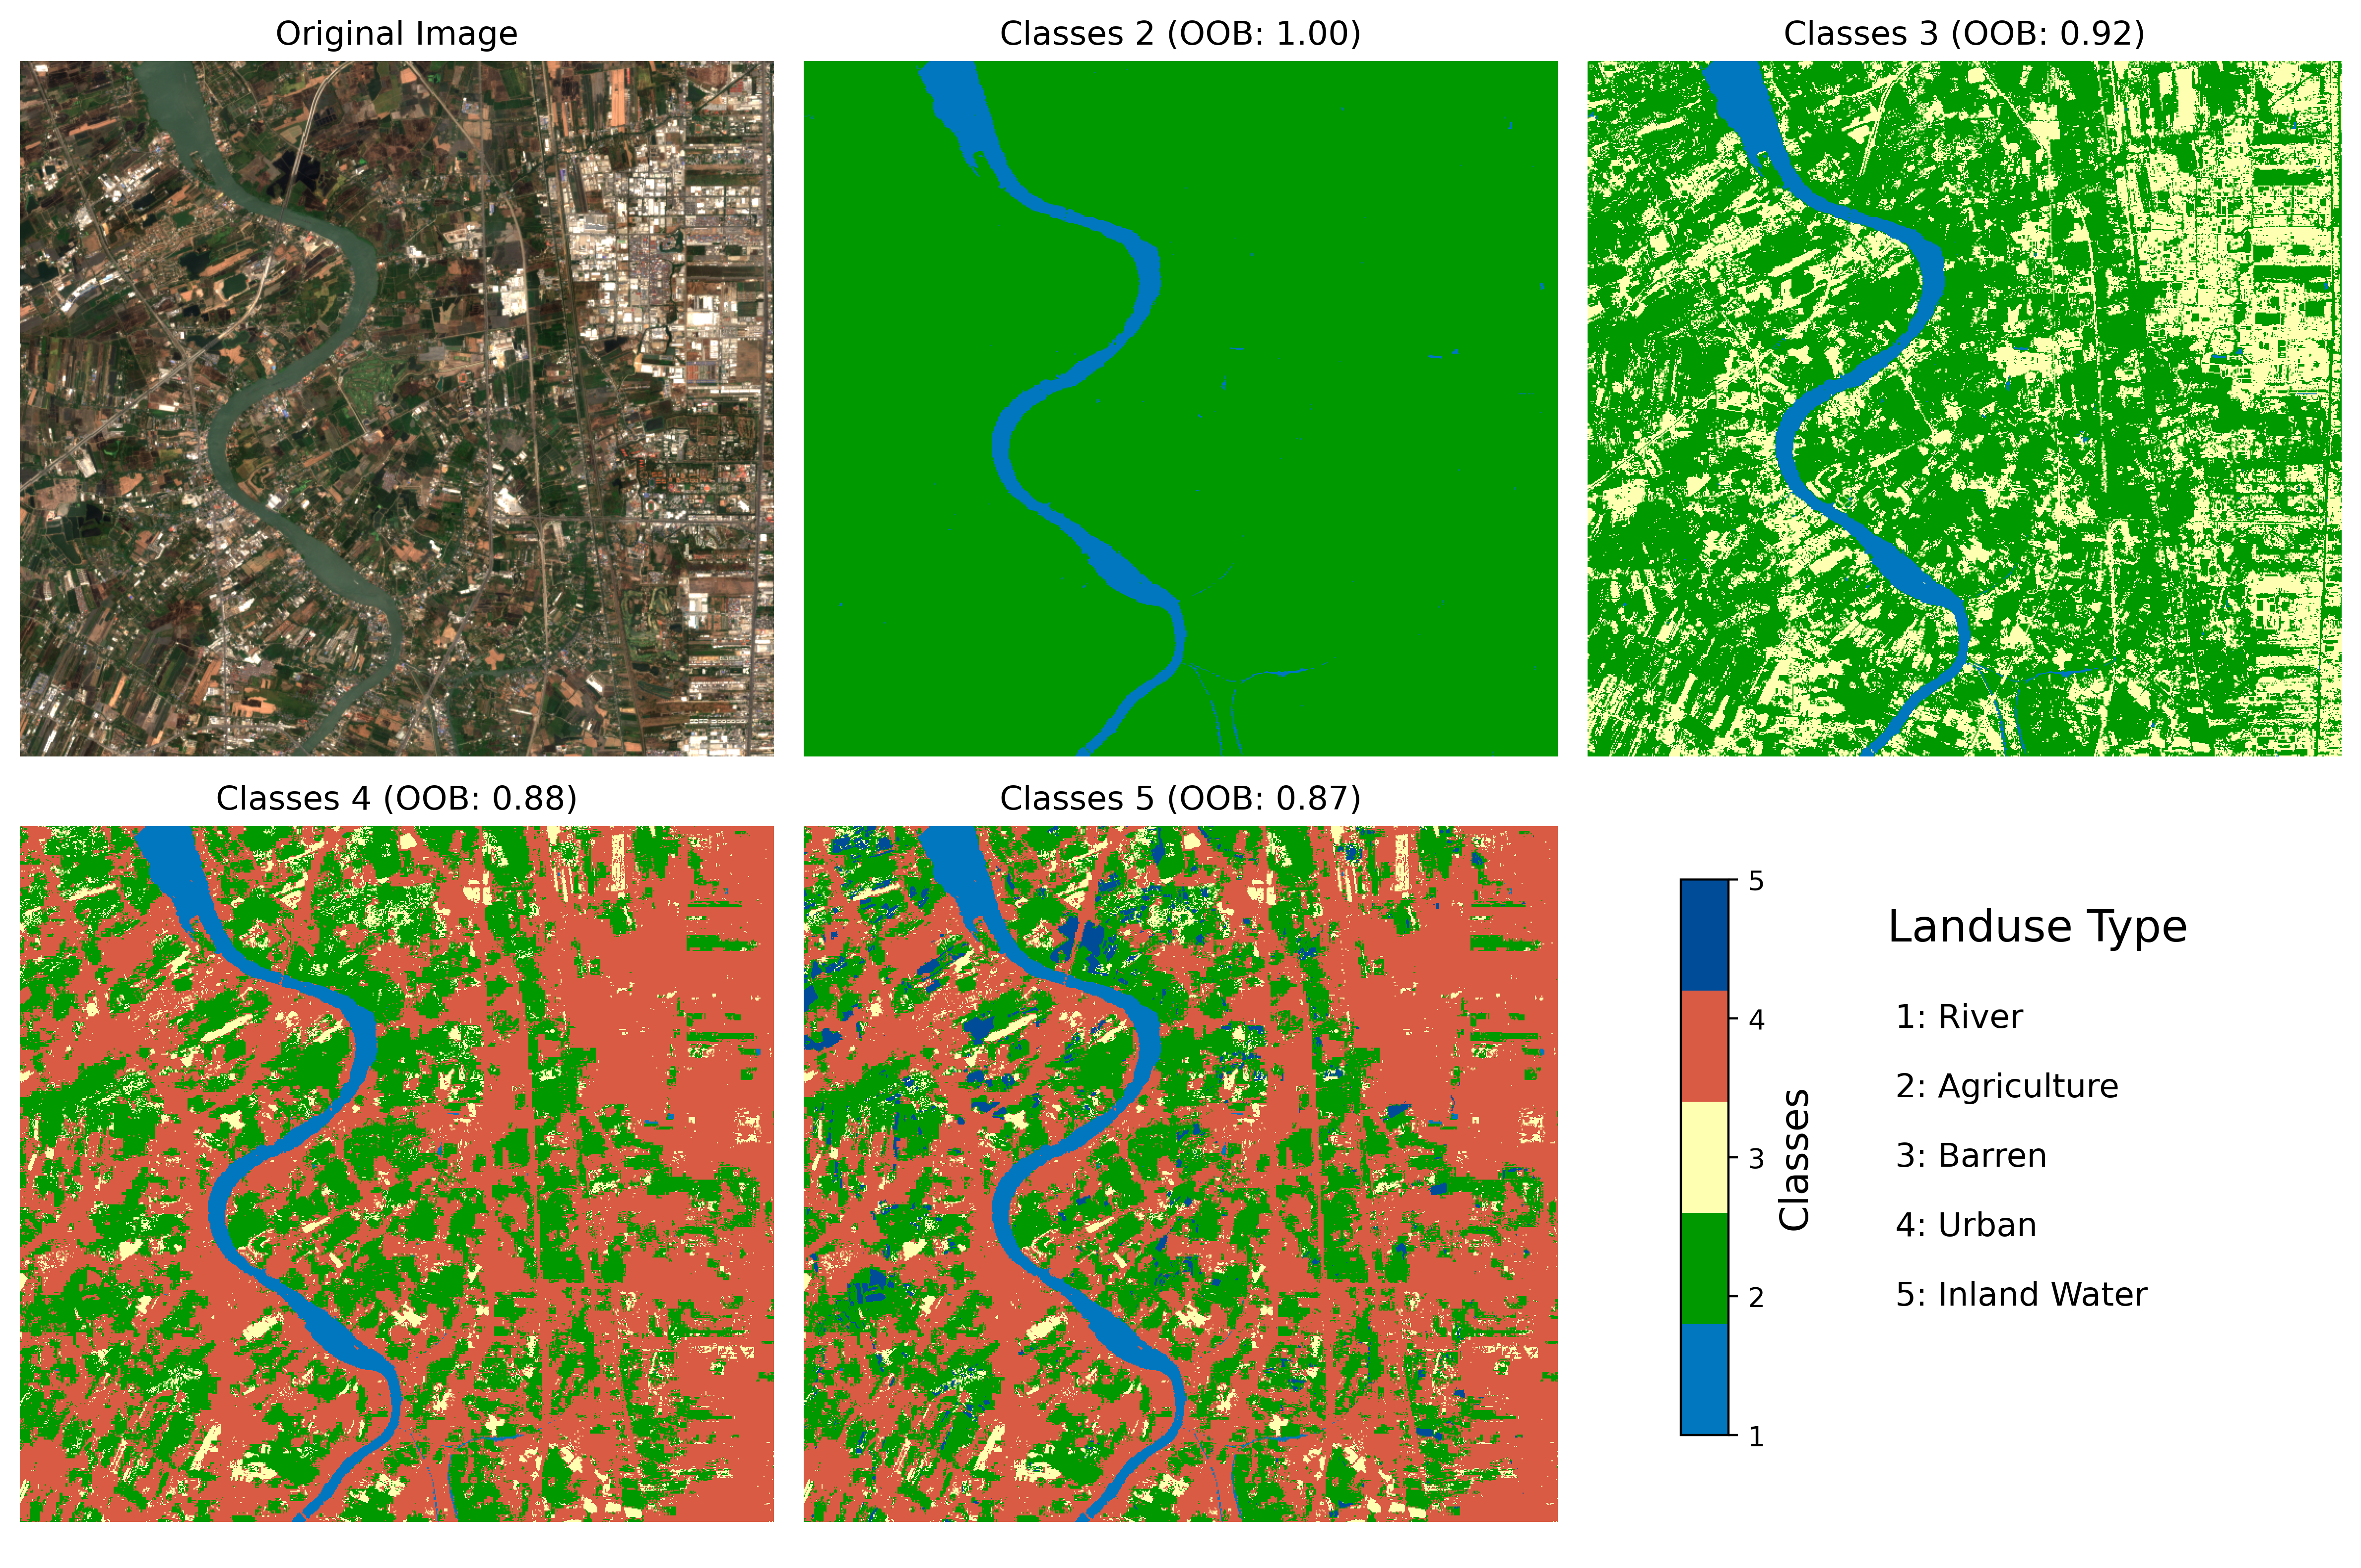

In [221]:
# Create a figure with 2 rows and 3 columns of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8), dpi=400)

# Flatten the axes array for easier indexing
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

# First subplot: Original image
ax1.imshow(img_p)
ax1.set_title("Original Image")
ax1.axis('off')  # Turn off axis

# Second subplot: Classified image 2
oob_score_2, class_prediction_2 = results['roi_2']
img2 = ax2.imshow(class_prediction_2, cmap=cmap2, interpolation='none')
ax2.set_title(f"Classes 2 (OOB: {oob_score_2:.2f})")
ax2.axis('off')  # Turn off axis

# Third subplot: Classified image 3
oob_score_3, class_prediction_3 = results['roi_3']
img3 = ax3.imshow(class_prediction_3, cmap=cmap3, interpolation='none')
ax3.set_title(f"Classes 3 (OOB: {oob_score_3:.2f})")
ax3.axis('off')  # Turn off axis

# Fourth subplot: Classified image 4
oob_score_4, class_prediction_4 = results['roi_4']
img4 = ax4.imshow(class_prediction_4, cmap=cmap4, interpolation='none')
ax4.set_title(f"Classes 4 (OOB: {oob_score_4:.2f})")
ax4.axis('off')  # Turn off axis

# Fifth subplot: Classified image 5
oob_score_5, class_prediction_5 = results['roi_5']
img5 = ax5.imshow(class_prediction_5, cmap=cmap5, interpolation='none')
ax5.set_title(f"Classes 5 (OOB: {oob_score_5:.2f})")
ax5.axis('off')  # Turn off axis

# Optionally: Sixth subplot can be used for other information or left empty
ax6.axis('off')  # Turn off axis for the empty subplot

# Define custom color bar axis outside the plots
cbar_ax = fig.add_axes([0.71, 0.09, 0.02, 0.35])  # Adjust (x, y, width, height) as needed

# Add color bar to custom axis, using the last classified image
cbar = fig.colorbar(img5, cax=cbar_ax, ticks=np.arange(1, 6))
cbar.set_label('Classes', fontsize=14)

# Add a title for the legend
cbar.ax.text(7.5, 4.8, 'Landuse Type', fontsize=16, va='top', ha='center')

# Add class labels next to the color bar with increased line spacing in reverse order
class_labels = ['1: River', '2: Agriculture', '3: Barren', '4: Urban', '5: Inland Water']
spacing = 0.5  # Adjust this value to increase/decrease spacing

cbar.ax.text(4.5, 4, class_labels[0], va='center', fontsize=12, ha='left')
cbar.ax.text(4.5, 3.5, class_labels[1], va='center', fontsize=12, ha='left')
cbar.ax.text(4.5, 3.0, class_labels[2], va='center', fontsize=12, ha='left')
cbar.ax.text(4.5, 2.5, class_labels[3], va='center', fontsize=12, ha='left')
cbar.ax.text(4.5, 2.0, class_labels[4], va='center', fontsize=12, ha='left')
    
# Use tight_layout and show the plot
plt.tight_layout()
plt.show()


This comparison shows us that having a higher number of classes helps in better prediction. While using only 2 classes, we obtained an OOB score of 1. This does not mean that the model is perfect. When we increase the classes to 3, the OOB score decreases to 0.92. But, the performance seems to improve as the barren areas are seen. Similarly, while all 5 classes were provided, the OOB score is 0.87. Now the model has provided a much better and enhanced visualization. Therefore, combining all the datasets into one ROI to train the model helped the model for a much more accurate land use classification visualisation. 

### Are all bands required?
In remote sensing and multi-spectral imaging, different bands correspond to specific wavelengths of the electromagnetic spectrum. When working with images, using just the RGB bands—red, green, and blue—can be enough for basic visualization and some straightforward analyses. However, if we are aiming for a more precise and detailed classification of land cover, especially in complicated environments, it’s really advantageous to include additional spectral bands. We have only used the 3 bands.

In [233]:
n_estimators_range = [10, 50, 100, 200, 500]  # Define the range of estimators
oob_scores = {}  # Dictionary to store OOB scores

# Loop through the n_estimators values
for n in n_estimators_range:
    print(f"\nTraining with n_estimators={n}")
    oob_score, class_prediction = train_and_classify(img, roi_df_c, n_estimators=n)
    oob_scores[n] = oob_score
    print(f"OOB score for n_estimators={n}: {oob_score:.4f}")


Training with n_estimators=10


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


OOB score for n_estimators=10: 0.8267

Training with n_estimators=50
OOB score for n_estimators=50: 0.8661

Training with n_estimators=100
OOB score for n_estimators=100: 0.8708

Training with n_estimators=200
OOB score for n_estimators=200: 0.8715

Training with n_estimators=500
OOB score for n_estimators=500: 0.8713


Based on the OOB scores obtained from different values of n_estimators, we can observe
1. **Performance improvement with more trees** (Initially)
   Initially, increasing the number of estimators significantly improves the model’s OOB score, suggesting better model performance and generalization. Moving from 10 to 50 trees increased the OOB score from 0.8267 to 0.8661,
2. **Diminishing Results**
   As we increase the number of trees, the improvement does not seem so significant. From 100 to 500, we only see very slight increase.
3. **Optimal**
   Based on the results, using 200 trees might be the reasonable choice as adding 300 more trees results almost the same OOB score. So if we get the same result with lower computational resources used, why not.

### Conclusion
At first, increasing the number of estimators significantly improves the model's accuracy. However, after about 200 trees, the gains become very small, meaning we’re getting only a slight improvement despite adding many more trees. With this dataset, using 200 estimators seems to strike a good balance,it provides strong accuracy without the extra computational cost that would come from using even more trees. So, 200 estimators is likely the best choice here. However, it does not support much to the fact that we can vastly change the accuracy.